In [21]:
import pandas as pd
from hydroDL.data import usgs, gageII, gridMET, ntn, GLASS, transform, dbBasin
import numpy as np
import matplotlib.pyplot as plt
from hydroDL.post import axplot, figplot, mapplot
from hydroDL import kPath, utils
import json
import os
import importlib
from hydroDL.master import basinFull
from hydroDL.app.waterQuality import WRTDS
import matplotlib
import matplotlib.gridspec as gridspec



In [22]:

dataName='G200'
DF = dbBasin.DataFrameBasin(dataName)

Find negative Q, filled zero


c:\Users\geofk\anaconda3\envs\pytorch\lib\site-packages\numpy\lib\nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


3038 extremes removed
loading data G200 30.47s


# DataFrameBasin 
DataFrameBasin compiled dynamic and static data on basins/sites, including:

1. basic information

time related: DF.t, DF.sd, DF.ed, DF.freq

locations: DF.lat, DF.lon

siteNo:DF.siteNoLst

2. time series data in [#time, #sites, #variables], including
- DF.c - water quality concentration
- DF.q - streamflow
- DF.f - climate forcings

and corresponding variables as DF.varC, DF.varQ, DF.varF

3. static data in [#sites, #variables]
- DF.g 
- DF.varG

In [23]:
## example: load concentration, streamflow and precipitation
# load Ca concentration
code = "00915"
indC = DF.varC.index(code)
matC = DF.c[:,  :,indC]
# load runoff
varQ = "runoff"
matQ = DF.q[:, :, DF.varQ.index(varQ)]
# load precipitation
varF = "pr"
matF = DF.f[:, :, DF.varF.index(varF)]
# load basin area
varG = "DRAIN_SQKM"
matG = DF.g[:, DF.varG.index(varG)]


Text(0.5, 1.0, '07083000')

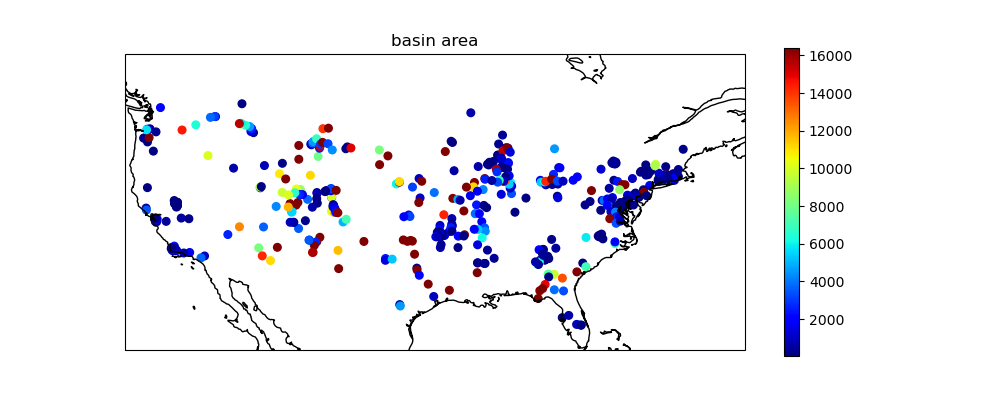

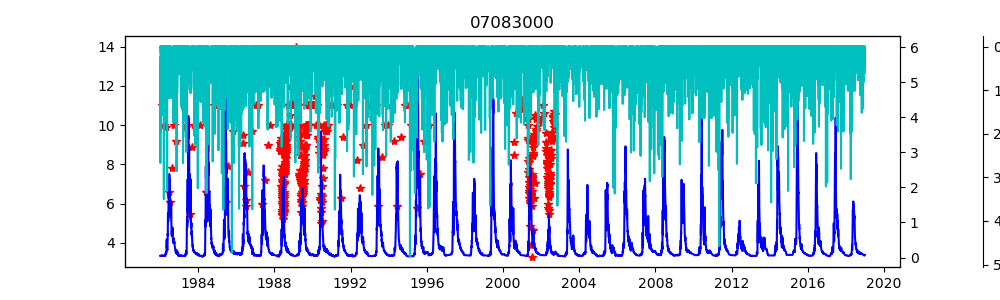

In [24]:
# plot
lat, lon = DF.getGeo()
figM = plt.figure(figsize=(10, 4))
gsM = gridspec.GridSpec(1, 1)
axM = mapplot.mapPoint(figM, gsM[0, 0], lat, lon, matG)
axM.set_title("basin area")
# figM.show()

iP=300
figP, axP = plt.subplots(1, 1, figsize=(10, 3))
axT1 = axP.twinx()
axT2 = axP.twinx()
axT2.spines["right"].set_position(("outward", 60))
axT2.invert_yaxis()
axT2.plot(DF.t, matF[:, iP],'c-',label='precipitation')
axT1.plot(DF.t, matQ[:, iP],'b-',label='runoff')
axP.plot(DF.t, matC[:, iP],'r*',label=usgs.getCodeStr(code))
titleStr = "{}".format(DF.siteNoLst[iP])
axP.set_title(titleStr)

In [ ]:

# train LSTM model
dataName = 'G200'
label = 'QFPRT2C'
# DF = dbBasin.DataFrameBasin(dataName)
rho = 365
nbatch = 500
hs = 256
trainSet = 'rmYr5'
testSet = 'pkYr5'
varX = dbBasin.label2var(label.split('2')[0])
mtdX = dbBasin.io.extractVarMtd(varX)
varY = dbBasin.label2var(label.split('2')[1])
mtdY = dbBasin.io.extractVarMtd(varY)
varXC = gageII.varLst
mtdXC = dbBasin.io.extractVarMtd(varXC)
varYC = None
mtdYC = dbBasin.io.extractVarMtd(varYC)
outName = '{}-{}-{}-hs{}'.format(dataName, label, trainSet, hs)
dictP = basinFull.wrapMaster(
    outName=outName, dataName=dataName, trainSet=trainSet,
    nEpoch=500, saveEpoch=50, crit='RmseLoss3D',
    varX=varX, varY=varY, varXC=varXC, varYC=varYC,
    mtdX=mtdX, mtdY=mtdY, mtdXC=mtdXC, mtdYC=mtdYC,
    hiddenSize=hs, batchSize=[rho, nbatch])
# cmdP = 'python /home/users/kuaifang/GitHUB/geolearn/hydroDL/master/cmd/basinFull.py -M {}'
# slurm.submitJobGPU(outName, cmdP.format(outName), nH=24, nM=64)
basinFull.trainModel(outName)